In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈

# GPU 선택 -> '1': 두 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'come',
    'away',
    'spin'
]

data = np.concatenate([
    np.load('dataset/seq_come_1708447662.npy'),
    np.load('dataset/seq_away_1708447662.npy'),
    np.load('dataset/seq_spin_1708447662.npy')
], axis=0)

data.shape

(2533, 30, 100)

In [3]:
# 시퀀스의 마지막 열 제외한 모든 열 가져와 할당
# 마지막 열은 레이블 또는 타겟 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2533, 30, 99)
(2533,)


In [4]:
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2533, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2279, 30, 99) (2279, 3)
(254, 30, 99) (254, 3)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

# compile(옵티마이저, 손실함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44163 (172.51 KB)
Trainable params: 44163 (172.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, 50 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200


70/72 [============================>.] - ETA: 0s - loss: 3.1191 - acc: 0.7429
Epoch 1: val_acc improved from -inf to 0.73622, saving model to models\model.h5
72/72 [==============================] - 2s 13ms/step - loss: 3.0740 - acc: 0.7455 - val_loss: 1.3590 - val_acc: 0.7362 - lr: 0.0010
Epoch 2/200
13/72 [====>.........................] - ETA: 0s - loss: 0.8389 - acc: 0.8293

c:\Users\mshof\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/72 [============================>.] - ETA: 0s - loss: 0.5679 - acc: 0.8879
Epoch 2: val_acc improved from 0.73622 to 0.95669, saving model to models\model.h5
72/72 [==============================] - 1s 10ms/step - loss: 0.5589 - acc: 0.8899 - val_loss: 0.1595 - val_acc: 0.9567 - lr: 0.0010
Epoch 3/200
71/72 [============================>.] - ETA: 0s - loss: 0.4638 - acc: 0.9071
Epoch 3: val_acc did not improve from 0.95669
72/72 [==============================] - 1s 9ms/step - loss: 0.4637 - acc: 0.9070 - val_loss: 0.2496 - val_acc: 0.9449 - lr: 0.0010
Epoch 4/200
72/72 [==============================] - ETA: 0s - loss: 2.3816 - acc: 0.8135
Epoch 4: val_acc did not improve from 0.95669
72/72 [==============================] - 1s 10ms/step - loss: 2.3816 - acc: 0.8135 - val_loss: 0.4564 - val_acc: 0.8622 - lr: 0.0010
Epoch 5/200
69/72 [===========================>..] - ETA: 0s - loss: 0.2589 - acc: 0.9253
Epoch 5: val_acc did not improve from 0.95669
72/72 [==========================

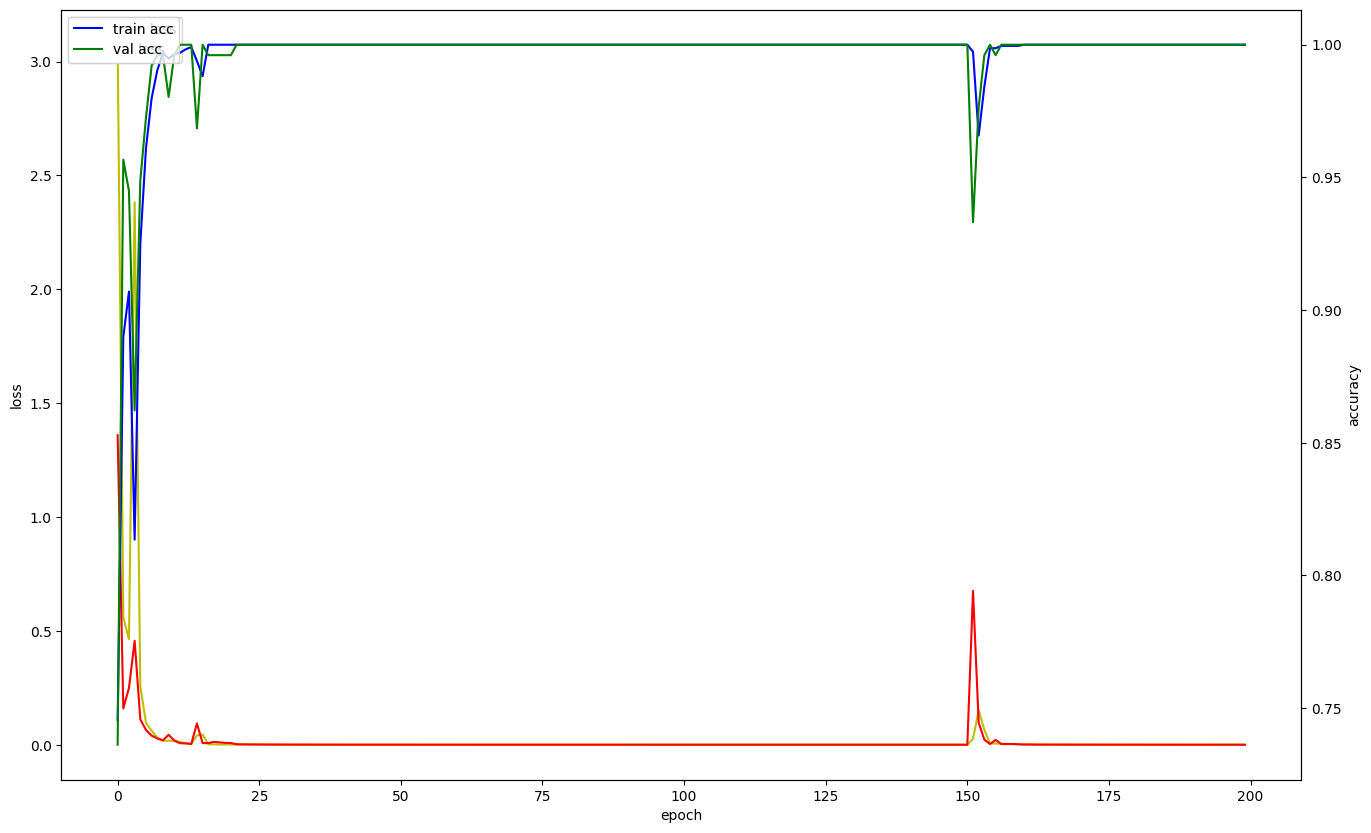

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

# 다중 레이블 혼동 행렬로 모델 평가
# [[True Negative, False Positive],
# [False Negative, True Positive]]
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

8/8 [==============================] - 0s 5ms/step


array([[[174,   0],
        [  0,  80]],

       [[168,   0],
        [  0,  86]],

       [[166,   0],
        [  0,  88]]], dtype=int64)